# Find wheels and rims in images, write rims as json file ##

Develop techniques for finding wheels (connected regions) in images and the rims that surround them. Here, look also at adding a border around the chosen wheels.

## Check directory contents 

In [11]:
#!dir "MCimages"
#!dir "Images/ControlBatch"
#!dir "Images/IrradiatedBatch"
!dir "CometImages/sim-img-train"

dir: cannot access 'CometImages/sim-img-train': No such file or directory


## Read image from file 

In [1]:
import datetime
now = datetime.datetime.now()
startNB = now
print("Date and time ",str(now))
#
import sys
import numpy as np
import os
import glob
import scipy.ndimage as scimg
import matplotlib.pyplot as plt
%matplotlib inline
#
# Control batch file numbers from  0001 to 0020
# Irradiated batch file numbers from 0001 to 0020
#imFile = "Images/ControlBatch/0020.bmp"
#imFile = "Images/IrradiatedBatch/0013.bmp"
#imFile = "Images/IrradiatedBatch/0013.bmp"
#imFile = "../CometImages/1st-set/Irradiated/0019.bmp"
#imFile = "../CometImages/4Gy/4Gy 0h-2irrad.bmp"
imFile = "../CometImages/exp-val/comets62.bmp"
fileName = [os.path.basename(x) for x in sorted(glob.glob(imFile))][0]
print("fileName is: ", fileName)
#########################
image_dir = 'CometImages/exp-val/*.bmp'  #where the image directory is - find all bmp files here
fileList= sorted(glob.glob(image_dir))  #whole file path, as set in above line
#print("Files read in (whole path) are", fileList)
#
fileNames = [os.path.basename(x) for x in sorted(glob.glob(image_dir))]
#imFile = "../CometImages/CA210609/Collated/4GyA/bmp/test/4GyA0024.bmp"
#
# Evidence tuning needed in e.g. Control 0009, Control 0019, Irradiated 0013, Irradiated 0018
#
# Read in image
imgRaw = plt.imread(imFile)
#
print(" ")
print("File " + imFile + " read.")
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-12-15 14:43:12.148101
fileName is:  comets62.bmp
 
File ../CometImages/exp-val/comets62.bmp read.
 
Date and time 2021-12-15 14:43:14.834138
Time since last check is 0:00:02.686037


## Some useful routines

Convert RGBA images to RGB and RGB to greyscale. Ceiling division.

In [2]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import numpy as np
#
def rgba2rgb(rgba, background = (255, 255, 255)):
    '''
    Function to convert RGBA images into RGB format. Input RGBA image (and background); output RGB image.
    '''
    rows, cols, chans = rgba.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
            return rgba
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 4, 'RGBA image must have 4 channels.'
    #
    rgb = np.zeros((rows, cols, 3), dtype = 'float32')
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]
    #
    a = np.asarray(a, dtype='float32')/255.0
    #
    R, G, B = background
    #
    rgb[:, :, 0] = r*a + (1.0 - a)*R
    rgb[:, :, 1] = g*a + (1.0 - a)*G
    rgb[:, :, 2] = b*a + (1.0 - a)*B
    #
    return np.asarray(rgb, dtype = np.uint8)
#
def rgb2grey(rgb, negative = 0, withHists = False):
    '''
    Convert RGB image to greyscale. Input RGB (and flag indicating negative required), output greyscale image.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    #
    grey[:, :] = (0.2125*(r*negative + (negative - 1.0)*r) + 
                  0.7154*(g*negative + (negative - 1.0)*g) + 
                  0.0721*(b*negative + (negative - 1.0)*b))
    if withHists:
        print(" ")
        print("Max intensities red",np.amax(r),"green",np.amax(g), "blue",np.amax(b))
        print(" ")
        nBins = int(256/8)
        nBins = 256
        plt.figure(figsize = (12, 9))
        plt.subplot(4, 1, 1)
        plt.hist(np.ravel(r), bins = nBins, color = 'r')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 2)
        plt.hist(np.ravel(g), bins = nBins, color = 'g')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 3)
        plt.hist(np.ravel(b), bins = nBins, color = 'b')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.subplot(4, 1, 4)
        plt.hist(np.ravel(grey), bins = nBins, color = 'k')
        plt.yscale("log")
        plt.xlim(-1, 256)
        plt.tight_layout()
        plt.show()
    #
    return np.asarray(grey, dtype = np.uint8)
#
def ceilDiv(a, b):
    '''
    Return a//b rounded up.
    '''
    ceiling = -(-a//b)
    return ceiling
#
############################################
def rgbSeperate(rgb, filename, withPlots = False):
    '''
    Seperate RGB image into the R, G, B components and plot image in each of these individual channels.
    '''
    rows, cols, chans = rgb.shape
    #
    debug = False
    #
    if debug:
        if chans == 4:
            print("RGBA image")
        elif chans == 3:
            print("RGB image")
        elif chans == 1:
            print("Greyscale image")
            return rgb
        else:
            print("Channel number is",chans)
            sys.exit()
    else:
        assert chans == 3, 'RGB image must have 3 channels.'
    #
    #grey = np.zeros((rows, cols), dtype = 'float32')
    #
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    if withPlots == True:
        plt.figure(figsize = (12, 9))
        plt.subplot(2, 2, 1)
        plt.title("raw image" + str(filename))
        plt.imshow(rgb, cmap='afmhot')
        plt.subplot(2, 2, 2)
        plt.title("red channel")
        plt.imshow(r, cmap='afmhot')
        plt.subplot(2, 2, 3)
        plt.title("green channel")
        plt.imshow(g, cmap='afmhot')
        plt.subplot(2, 2, 4)
        plt.title("blue channel")
        plt.imshow(b, cmap='afmhot')
        plt.show()
    
    return r, g, b
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-12-15 14:43:21.623875
 
Date and time 2021-12-15 14:43:21.625050
Time since last check is 0:00:00.001175


## Initial image processing

Open image, convert to grey scale and apply thresholds.

Date and time  2021-12-15 14:43:23.375762
 
Max intensities red 254 green 254 blue 155
 


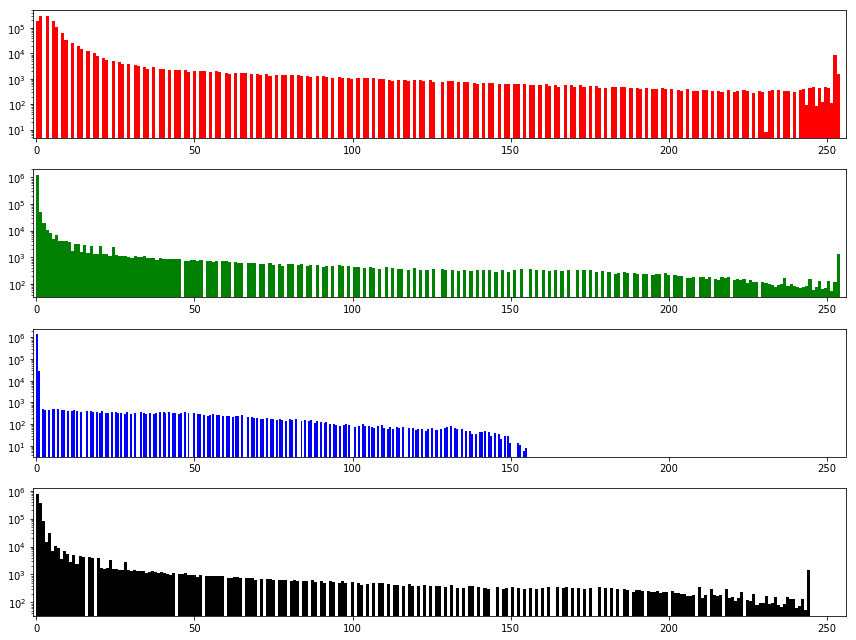

Type of raw image file is uint8
Type of greyscale image file is uint8
Number of rows 1040 of columns 1392 of pixels 1447680 and depth 4
Maximum pixel value  244
Minimum pixel value  0
 
Number of thresholds 2
Number of rows in figure 2
 


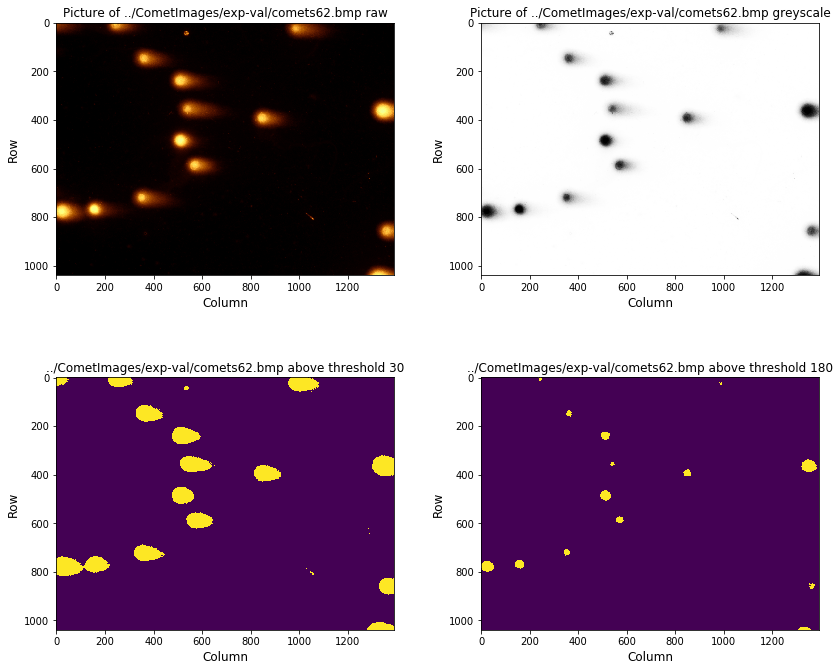

 
Date and time 2021-12-15 14:43:29.136540
Time since last check is 0:00:05.760778


In [3]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
withHists = True
#
# Set thresholds for applying to image (lowest to highest)
thresh = np.array([30, 180]) 
#thresh = np.array([30, 100]) # was 10, 100
#thresh = np.array([30, 180, 225])
#
#def processImage(imgRaw, hotCut):
def processImage(imgRaw):
    #
    import sys
    import numpy as np
    import scipy.ndimage as scimg
    import matplotlib.pyplot as plt
    %matplotlib inline
    # 
    # Number of rows and columns. Depth is 3 for RGB, 4 for RGBA image. A is opacity (alpha)
    nRows = imgRaw.shape[0] 
    nCols = imgRaw.shape[1]
    if len(imgRaw.shape) == 3:
        nDepth = imgRaw.shape[2]
    else:
        nDepth = 1
    #
    nThresh = len(thresh)
    img = np.zeros((nRows, nCols))
    imgThr = np.zeros((nRows, nCols, nThresh))
    #
    # Determine image format and process accordingly
    if nDepth == 4:
        imgRGB = rgba2rgb(imgRaw)
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 3:
        imgRGB = imgRaw
        imgGrey = rgb2grey(imgRGB, 1, withHists)
    elif nDepth == 1:
        imgRGB = imgRaw
        imgGrey = imgRaw
    else:
        print(" ")
        print("Unexpected image depth",nDepth)
        sys.stop()
    #
    """
    # Remove "hot" pixels
    print(" ")
    print("Maximum pixel value before removing hot pixels",np.amax(imgGrey))
    print("Minimum pixel value ",np.amin(imgGrey))
    hotPixels = imgGrey > hotCut
    imgGrey[hotPixels] = 0
    #
    # Rescale 
    #imgGrey = np.asarray(255//hotCut*imgGrey, dtype = np.uint8)
    imgGrey = np.asarray((255/hotCut)*imgGrey, dtype = np.uint8)
    """
    #
    print("Type of raw image file is",imgRaw.dtype)
    print("Type of greyscale image file is",imgGrey.dtype)
    print("Number of rows",nRows,"of columns",nCols,"of pixels",nRows*nCols,"and depth",nDepth)
    #print("Hot pixel cut",hotCut)
    #print("Number of hot pixels",np.sum(hotPixels))
    #print("Maximum pixel value after removing hot pixels",np.amax(imgGrey))
    print("Maximum pixel value ", np.amax(imgGrey))
    print("Minimum pixel value ",np.amin(imgGrey))
    #
    return imgGrey, nRows, nCols
#
# Set thresholds for applying to image (lowest to highest)
#thresh = np.array([10, 180]) 
#thresh = np.array([10, 100]) 
#thresh = np.array([30, 180, 225])
#
# Read in image
imgRaw = plt.imread(imFile)
#
#hotCut = 255  #was 230
imgGrey, nRows, nCols = processImage(imgRaw) #previously alos had hotCut argument
#
nThresh = len(thresh)
imgThr = np.zeros((nRows, nCols, nThresh))
#
# Plot image at various stages of processing
nFigRows = 1 + ceilDiv(nThresh, 2)
print(" ")
print("Number of thresholds",nThresh)
print("Number of rows in figure",nFigRows)
for nT in range(0, nThresh):
    imgThr[:, :, nT] = imgGrey > thresh[nT]
#
print(" ")
fig = plt.figure(figsize=(nFigRows*6, 10))
fig.add_subplot(nFigRows, 2, 1)
plt.title("Picture of " + imFile + " raw")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgRaw, cmap = "jet")
#mgplot = plt.imshow(imgRaw)
#
fig.add_subplot(nFigRows, 2, 2)
plt.title("Picture of " + imFile + " greyscale")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
imgplot = plt.imshow(imgGrey, cmap = "Greys")
#imgplot = plt.imshow(imgGrey)

#
for nT in range(0, nThresh):
    fig.add_subplot(nFigRows, 2, 3 + nT)
    plt.title(imFile + " above threshold " + str(thresh[nT]))
    plt.xlabel('Column', fontsize = 12)
    plt.ylabel('Row', fontsize = 12)
    imgplot = plt.imshow(imgThr[:, :, nT])
#
plt.tight_layout()
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Identify clusters using watershed algorithm

Identify "clusters" at the lowest threshold and "heads" at the higher threshold.

Date and time 2021-12-15 14:43:33.201945
 
Cluster ID using Watershed algorithm
Cluster threshold 30, head threshold 180.
Min number of pixels in cluster 2000, max number 200000.
Min number of pixels in head 100, max number 20000.
 


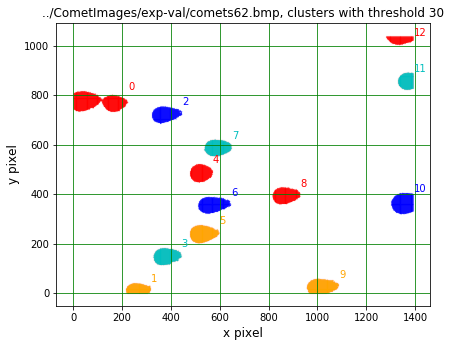

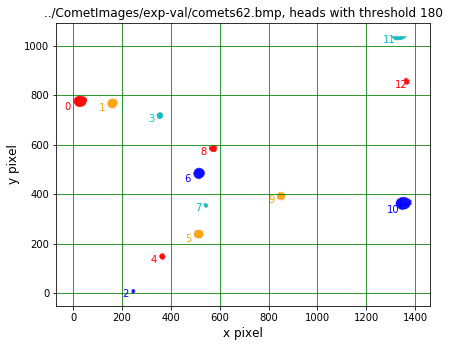

 
Date and time 2021-12-15 14:43:37.271906
Time since last check is 0:00:04.069961


In [4]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
#
import scipy
import scipy.ndimage as ndimage
import scipy.ndimage.filters as filters
from skimage.feature import peak_local_max
#
debug = False
#
# Requirements on minimum and maximum number of pixels in wheels at the cluster and head thresholds
minClusPixels = 2000
maxClusPixels = 200000
minHeadPixels = 100 
maxHeadPixels = 20000
#
print(" ")
print("Cluster ID using Watershed algorithm")
print("Cluster threshold",thresh[0],"\b, head threshold",thresh[1],"\b.")
print("Min number of pixels in cluster",minClusPixels,"\b, max number",maxClusPixels,"\b.")
print("Min number of pixels in head",minHeadPixels,"\b, max number",maxHeadPixels,"\b.")
#
# Define grid of markers and background marker value:
nStepCols = 3
nStepRows = 3
#
# Ensure rMark + 1 (used later) doesn't cause overflow in number of image rows (i.e. rMark + 1 < nRows)
if nRows%nStepRows > 1:
    rMarkTop = nRows
else:
    rMarkTop = nRows - nStepRows
rMark, cMark = np.ogrid[0:rMarkTop:nStepRows, 0:nCols:nStepCols]
if debug:
    print(" ")
    print("rMark.shape",rMark.shape,"cMark.shape",cMark.shape)
mStart = 1
markers = np.zeros((nRows, nCols)).astype(np.int)
markers[rMark, cMark] = rMark/nStepRows + cMark*nRows/(nStepRows*nStepCols) + mStart

if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(markers, cmap = "CMRmap");
#
# Create image with cluster threshold and run watershed algorithm
#imgGrey = R
clusImg = imgGrey > thresh[0]
"""
distance = ndimage.distance_transform_edt(clusImg)
local_maxi = peak_local_max(distance, indices=False, labels = clusImg)
markers = ndimage.label(local_maxi)[0]
"""
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusImg);
colDotsClus = ndimage.watershed_ift(clusImg.astype(np.uint8), markers)
#
# Remove "isolated" markers (i.e. markers in regions where no cluster found)
#colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
colDotsClus[rMark, cMark] = colDotsClus[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions
mMaxClus = np.amax(colDotsClus)
#
# Positions of marker values
boolClus = colDotsClus >= mStart
nFoundClus = len(np.unique(colDotsClus[boolClus]))
rMarkerClus = np.zeros(nFoundClus)
rMarkerClus = np.unique(colDotsClus[boolClus])
#
# Select the clusters, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nClus = 0
cMarkerClus = np.zeros(nFoundClus)
maxInDotClus = 0
for nR in range(0, nFoundClus):
    boolClus = colDotsClus == rMarkerClus[nR]
    nHereCl = np.sum(boolClus)
    if nHereCl < minClusPixels or nHereCl > maxClusPixels:
        continue
    maxInDotClus = max(maxInDotClus, nHereCl)
    cMarkerClus[nClus] = rMarkerClus[nR]
    nClus += 1
#
# Create image with head threshold and run watershed algorithm
headImg = imgGrey > thresh[1]
if debug:
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headImg);
colDotsHead = ndimage.watershed_ift(headImg.astype(np.uint8), markers)
#
# Remove "isolated" markers
colDotsHead[rMark, cMark] = colDotsHead[rMark + 1, cMark]
#
# Find the value of the marker of the last identified regions.
mMaxHead = np.amax(colDotsHead)
#
# Positions of marker values that are not background
boolHead = colDotsHead > mStart
nFoundHead = len(np.unique(colDotsHead[boolHead]))
rMarkerHead = np.zeros(nFoundHead)
rMarkerHead = np.unique(colDotsHead[boolHead])
#
# Select the heads, first pass (determine accepted number). Must exclude tiny clusters (noise) and any 
# really large clusters (background regions in image).
nHead = 0
cMarkerHead = np.zeros(nFoundHead)
maxInDotHead = 0
for nR in range(0, nFoundHead):
    boolHead = colDotsHead == rMarkerHead[nR]
    nHereHd = np.sum(boolHead)
    if nHereHd < minHeadPixels or nHereHd > maxHeadPixels:
        continue
    maxInDotHead = max(maxInDotHead, nHereHd) 
    cMarkerHead[nHead] = rMarkerHead[nR]
    nHead += 1
#
# Colour table for plots
nColTab = 4
colorTab = ['r', 'orange', 'b', 'c']
#
# Information on clusters
nInCluster = np.zeros(nClus).astype(int)
iClusSum = np.zeros(nClus)
#
# Information on pixels in clusters
lClus = np.sum(clusImg)
#
# Safe size of arrays would be number of pixels in image. Try to reduce size by using number of pixels in clusters
# The factor lFact can be used to expand array sizes
lFact = 4
indexCl = np.zeros(lFact*lClus)
cPixelsCl = np.zeros(lFact*lClus).astype(int)
rPixelsCl = np.zeros(lFact*lClus).astype(int)
iPixelsCl = np.zeros(lFact*lClus)
#
# Information on head
nInHead = np.zeros(nHead).astype(int)
iHeadSum = np.zeros(nHead)
#
# Information on pixels in head (lHead must be large enough...here probably larger than usually needed)
lHead = lClus
#indexHd = np.zeros(lHead)
#cPixelsHd = np.zeros(lHead).astype(int)
#rPixelsHd = np.zeros(lHead).astype(int)
#iPixelsHd = np.zeros(lHead)
indexHd = np.zeros(lFact*lHead)
cPixelsHd = np.zeros(lFact*lHead).astype(int)
rPixelsHd = np.zeros(lFact*lHead).astype(int)
iPixelsHd = np.zeros(lFact*lHead)
#
# Temporary information 
cPixelsHere = np.zeros(lClus).astype(int)
rPixelsHere = np.zeros(lClus).astype(int)
iPixelsHere = np.zeros(lClus)
thisPic = np.zeros((nRows, nCols))
#
# Find pixels in clusters, determine positions and plot 
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", clusters with threshold " + str(thresh[0]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
mSize = 0.001
#
nCol = 0
nLastCl = 0
for nC in range(0, nClus):
    #
    # Clusters
    boolClus = colDotsClus == cMarkerClus[nC]
    nHereCl = np.sum(boolClus).astype(int)
    #
    nInCluster[nC] = nHereCl
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolClus)
    thisPic.fill(0) 
    thisPic[rPixelsHere, cPixelsHere] = 1
    if debug:
        clusPic += thisPic
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iClusSum[nC] = np.sum(iPixelsHere)
    #
    indexCl[nLastCl:nLastCl + nHereCl] = nC*np.ones(nHereCl)
    cPixelsCl[nLastCl:nLastCl + nHereCl] = cPixelsHere[:]
    rPixelsCl[nLastCl:nLastCl + nHereCl] = rPixelsHere[:]
    iPixelsCl[nLastCl:nLastCl + nHereCl] = iPixelsHere[:]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHere[0:nHereCl]) + yOffMax
    cLab = np.amax(cPixelsHere[0:nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
# Find pixels in head, determine positions and plot
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", heads with threshold " + str(thresh[1]), fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMin = 15.0
yOffMin = 35.0
mSize = 0.001
#
nCol = 0
nLastHd = 0
for nH in range(0, nHead):
    boolHead = colDotsHead == cMarkerHead[nH]
    nHereHd = np.sum(boolHead).astype(int)
    #
    nInHead[nH] = nHereHd
    #
    # Indices of x and y pixels
    rPixelsHere, cPixelsHere = np.where(boolHead)
    #
    # Intensities in pixels
    iPixelsHere = imgGrey[rPixelsHere, cPixelsHere]
    iHeadSum[nH] = np.sum(iPixelsHere)
    #
    #print("\nnLastHd and nInHead are: ", nLastHd, nInHead[nH])
    #
    indexHd[nLastHd:nLastHd + nHereHd] = nC*np.ones(nInHead[nH])  #
    cPixelsHd[nLastHd:nLastHd + nHereHd] = cPixelsHere[0:nHereHd]
    rPixelsHd[nLastHd:nLastHd + nHereHd] = rPixelsHere[0:nHereHd]
    iPixelsHd[nLastHd:nLastHd + nHereHd] = iPixelsHere[0:nHereHd]
    #
    plt.scatter(cPixelsHere, rPixelsHere, s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsHere) - xOffMin
    cLab = np.amin(cPixelsHere) - yOffMin
    plt.text(cLab, rLab, str(nH), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make plots using stored cluster and head data

Date and time 2021-12-15 14:43:45.913115
 


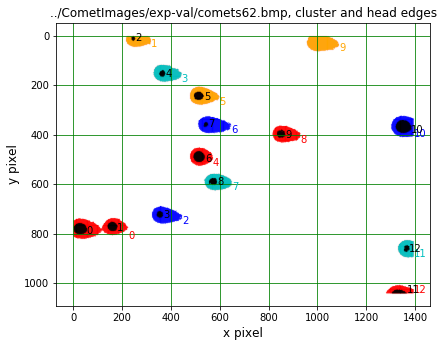

 
Date and time 2021-12-15 14:43:46.815133
Time since last check is 0:00:00.902018


In [5]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nCol = 0
#
nLastCl = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsCl[nLastCl:nLastCl + nHereCl]) + yOffMax
    cLab = np.amax(cPixelsCl[nLastCl:nLastCl + nHereCl]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastCl = nLastCl + nHereCl
    #
#
nCol = 0
nLastHd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHd = nLastHd + nHereHd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
plt.gca().invert_yaxis()
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Edge finding and cluster expansion

Algorithm used is to shift logical array `picture` containing thresholded image left, forming array `imgShift`. The array `not imgShift and picture` then contains the right edges in the original image. Shifts right, down and up allow the left, upper and lower edges to be found. "Corner" effects are taken care of by shifts in two doections (e.g. left and up). Taking the logical or of the results gives all edges.

In [6]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
def edgeFinderIn(picture, edgeWidth, useDiag = True):
    '''
    Return array containing pixels in edges (of width edgeWidth) of input (thresholded) image.
    The edges are inside the original image. The flag useDiag ensures "corner" pixels are selected.
    '''
    #
    shiftR = edgeWidth
    shiftC = edgeWidth
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    # Right edge
    imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
    imgShift[0:nRows, nCols - shiftC:nCols] = False
    edges = np.logical_and(picture, np.logical_not(imgShift))
    #
    # Left edge 
    imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
    imgShift[0:nRows, 0:shiftC] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Lower edge 
    imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
    imgShift[0:shiftR, 0:nCols] = False    
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    # Upper edge 
    imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
    imgShift[nRows - shiftR:nRows, 0:nCols] = False
    edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    if useDiag:
        #
        # Left upper edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Left lower edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right upper edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
        #
        # Right lower edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(picture, np.logical_not(imgShift)))
    #
    return edges
#
#
def expander(picture, edgeWidth, useDiag = True):
    '''
    Return array containing thresholded regions expanded by band of width edgeWidth. The flag useDiag ensures
    "corner" pixels are included correctly.
    '''
    #
    shiftR = 1
    shiftC = 1
    nRows, nCols = picture.shape
    edges = np.full((nRows, nCols), False)
    edgeSum = np.full((nRows, nCols), False)
    imgShift = np.full((nRows, nCols), False)
    #
    for  nE in range(0, edgeWidth):
        #
        # Left edge
        imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
        imgShift[0:nRows, nCols - shiftC:nCols] = False
        edges = np.logical_and(np.logical_not(picture), imgShift)
        #
        # Right edge 
        imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
        imgShift[0:nRows, 0:shiftC] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Upper edge 
        imgShift[shiftR:nRows, 0:nCols] = picture[0:nRows - shiftR, 0:nCols]
        imgShift[0:shiftR, 0:nCols] = False    
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        # Lower edge 
        imgShift[0:nRows - shiftR, 0:nCols] = picture[shiftR:nRows, 0:nCols]    
        imgShift[nRows - shiftR:nRows, 0:nCols] = False
        edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        if useDiag:
            #
            # Left upper edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Left lower edge
            imgShift[0:nRows, 0:nCols - shiftC] = picture[0:nRows, shiftC:nCols]
            imgShift[0:nRows, nCols - shiftC:nCols] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right upper edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[shiftR:nRows, 0:nCols] = imgShift[0:nRows - shiftR, 0:nCols]
            imgShift[0:shiftR, 0:nCols] = False    
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
            #
            # Right lower edge 
            imgShift[0:nRows, shiftC:nCols] = picture[0:nRows, 0:nCols - shiftC]
            imgShift[0:nRows, 0:shiftC] = False
            imgShift[0:nRows - shiftR, 0:nCols] = imgShift[shiftR:nRows, 0:nCols]    
            imgShift[nRows - shiftR:nRows, 0:nCols] = False
            edges = np.logical_or(edges, np.logical_and(np.logical_not(picture), imgShift))
        #
        picture = np.logical_or(picture, edges)
        edgeSum = np.logical_or(edges, edgeSum)
    #
    return picture, edgeSum
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time 2021-12-15 14:43:52.728505
 
Date and time 2021-12-15 14:43:52.730601
Time since last check is 0:00:00.002096


## Expand clusters and plot

Date and time 2021-12-15 14:44:03.400289
 


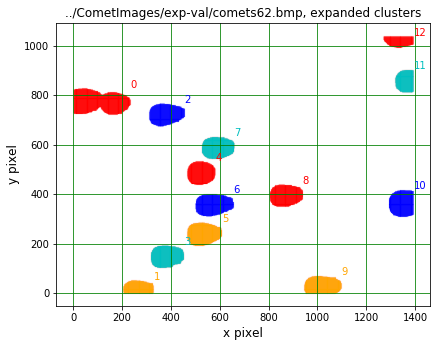

 
Date and time 2021-12-15 14:44:09.020841
Time since last check is 0:00:05.620552


In [7]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
useDiag = True
#
# Temporary information 
lFact = 1
cPixelsHere = np.zeros(lFact*lClus).astype(int)
rPixelsHere = np.zeros(lFact*lClus).astype(int)
thisPicEx = np.zeros((nRows, nCols))
thisEdge = np.zeros((nRows, nCols))
#
# Information on expanded cluster
nInClusEx = np.zeros(nClus).astype(int)
iClusExSum = np.zeros(nClus)
#
# Information on pixels in expanded cluster
lFact = 30
indexClEx = np.zeros(lFact*lClus)
cPixelsClEx = np.zeros(lFact*lClus).astype(int)
rPixelsClEx = np.zeros(lFact*lClus).astype(int)
iPixelsClEx = np.zeros(lFact*lClus)
#
# Information on edge
nInEdge = np.zeros(nClus).astype(int)
iEdgeSum = np.zeros(nClus)
#
# Information on pixels in expanded edge
lFact = 3
indexEdge = np.zeros(lFact*lClus)
cPixelsEdge = np.zeros(lFact*lClus).astype(int)
rPixelsEdge = np.zeros(lFact*lClus).astype(int)
iPixelsEdge = np.zeros(lFact*lClus)
#
# Pictures before and after expanding and edges (all clusters)
clusPic = np.zeros((nRows, nCols))
clusPicEx = np.zeros((nRows, nCols))
edgePic = np.zeros((nRows, nCols))
#
# Expansion required
widthEx = 10
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded clusters", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
nLastCl = 0
nLastClEx = 0
nLastEdge = 0
nCol = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereCl = nInCluster[nC]
    #
    # Indices of x and y pixels
    thisPic.fill(0) 
    thisPic[rPixelsCl[nLastCl:nLastCl + nHereCl], cPixelsCl[nLastCl:nLastCl + nHereCl]] = 1
    clusPic += thisPic
    #
    nLastCl = nLastCl + nHereCl
    #
    # Expand cluster
    thisExp, thisEdge = expander(thisPic, widthEx, useDiag)
    nHereClEx = np.sum(thisExp).astype(int)
    nInClusEx[nC] = nHereClEx
    #
    # Indices of x and y pixels expanded cluster
    rPixelsHereEx, cPixelsHereEx = np.where(thisExp)
    thisPicEx.fill(0)
    thisPicEx[rPixelsHereEx, cPixelsHereEx] = 1
    clusPicEx += thisPicEx
    #
    # Intensities in pixels expanded cluster
    iPixelsHereEx = imgGrey[rPixelsHereEx, cPixelsHereEx]
    iClusExSum[nC] = np.sum(iPixelsHereEx)
    #
    indexClEx[nLastClEx:nLastClEx + nHereClEx] = nC*np.ones(nHereClEx)
    cPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = cPixelsHereEx[:]
    rPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = rPixelsHereEx[:]
    iPixelsClEx[nLastClEx:nLastClEx + nHereClEx] = iPixelsHereEx[:]
    #
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Expanded edges
    nHereEdge = np.sum(thisEdge).astype(int)
    nInEdge[nC] = nHereEdge
    #
    # Indices of x and y pixels edge
    rPixelsHereEdge, cPixelsHereEdge = np.where(thisEdge)
    thisEdge.fill(0)
    thisEdge[rPixelsHereEdge, cPixelsHereEdge] = 1
    edgePic += thisEdge
    #
    # Intensities in pixels edge
    iPixelsHereEdge = imgGrey[rPixelsHereEdge, cPixelsHereEdge]
    iEdgeSum[nC] = np.sum(iPixelsHereEdge)
    #
    indexEdge[nLastEdge:nLastEdge + nHereEdge] = nC*np.ones(nHereEdge)
    cPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = cPixelsHereEdge[:]
    rPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = rPixelsHereEdge[:]
    iPixelsEdge[nLastEdge:nLastEdge + nHereEdge] = iPixelsHereEdge[:]
    nLastEdge = nLastEdge + nHereEdge
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPic);
    plt.show()
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPicEx);
    plt.show()
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(edgePic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded edges

Date and time 2021-12-15 14:44:12.371822
 


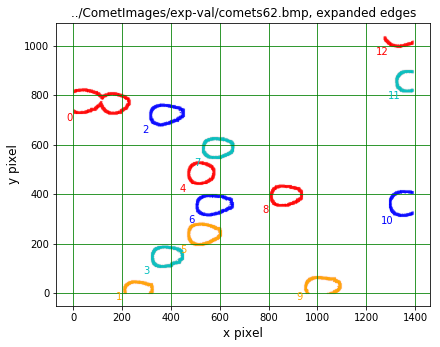

 
Date and time 2021-12-15 14:44:13.021877
Time since last check is 0:00:00.650055


In [8]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
nLastEdge = 0
nCol = 0
for nC in range(0, nClus):
    #
    # Edges
    nHereEdge = nInEdge[nC]
    #
    plt.scatter(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge], rPixelsEdge[nLastEdge:nLastEdge + nHereEdge], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amin(rPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - yOffMin
    cLab = np.amin(cPixelsEdge[nLastEdge:nLastEdge + nHereEdge]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastEdge = nLastEdge + nHereEdge
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Find edges of expanded clusters and plot

Date and time 2021-12-15 14:44:15.511345
 


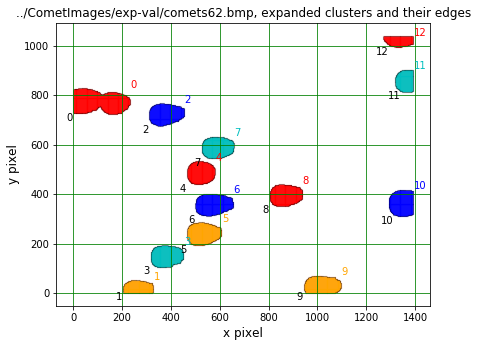

 
Date and time 2021-12-15 14:44:18.318582
Time since last check is 0:00:02.807237


In [9]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
useDiag = True
#
clusPic = np.zeros((nRows, nCols))
headPic = np.zeros((nRows, nCols))
#
# Information on cluster edge
nInClusEd = np.zeros(nClus).astype(int)
iClusEdSum = np.zeros(nClus)
#
# Information on pixels in cluster edge
lFact = 1
indexClEd = np.zeros(lFact*lClus)
cPixelsClEd = np.zeros(lFact*lClus)
rPixelsClEd = np.zeros(lFact*lClus)
iPixelsClEd = np.zeros(lFact*lClus)
#
# Pictures for display/edge finding
thisEdge = np.zeros((nRows, nCols))
thisEdgePic = np.zeros((nRows, nCols))
#
# Edge width required
width = 1
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", expanded clusters and their edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
nCol = 0
mSize = 0.001
#
nLastClEx = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    #
    # Indices of x and y pixels
    thisPic.fill(0)
    thisPic[rPixelsClEx[nLastClEx:nLastClEx + nHereClEx], cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]] = 1
    clusPic += thisPic
    #
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab[nCol])
    #
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Edges
    thisEdge = edgeFinderIn(thisPic, width, useDiag)
    nHereClEd = np.sum(thisEdge).astype(int)
    #
    nInClusEd[nC] = nHereClEd
    #
    # Indices of x and y pixels
    rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
    thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
    #
    # Intensities in pixels
    iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
    iClusEdSum[nC] = np.sum(iPixelsHereEd)
    #
    indexClEd[nLastClEd:nLastClEd + nHereClEd] = nC*np.ones(nInClusEd[nC])
    cPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = cPixelsHereEd[0:nHereClEd]
    rPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = rPixelsHereEd[0:nHereClEd]
    iPixelsClEd[nLastClEd:nLastClEd + nHereClEd] = iPixelsHereEd[0:nHereClEd]
    #
    plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHereEd[0:nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsHereEd[0:nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastClEd = nLastClEd + nHereClEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(clusPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make image of heads, find their edges and plot

Date and time 2021-12-15 14:44:20.115750
 


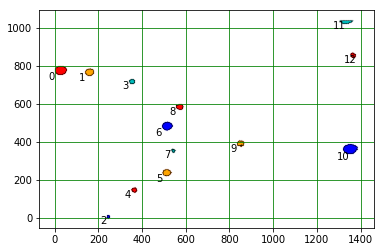

 
Date and time 2021-12-15 14:44:21.751134
Time since last check is 0:00:01.635384


In [10]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
debug = False
if debug:
    print("Running in debug mode!")
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
nCol = 0
mSize = 0.001
#
# Information on head edge
width = 1
nInHeadEd = np.zeros(nHead).astype(int)
iHeadEdSum = np.zeros(nHead)
#
# Information on pixels in head edge
indexHdEd = np.zeros(lHead)
cPixelsHdEd = np.zeros(lHead).astype(int)
rPixelsHdEd = np.zeros(lHead).astype(int)
iPixelsHdEd = np.zeros(lHead)
#
# Pictures for display/edge finding
headPic = np.zeros((nRows, nCols))
#
nLastHd = 0
nLastHdEd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    thisPic.fill(0)
    thisPic[rPixelsHd[nLastHd:nLastHd + nHereHd], cPixelsHd[nLastHd:nLastHd + nHereHd]] = 1
    headPic += thisPic
    #
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = colorTab[nCol], marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    nCol += 1
    if nCol > nColTab - 1:
         nCol = 0
    #
    nLastHd = nLastHd + nHereHd
    #
    # Edges
    thisEdge = edgeFinderIn(thisPic, width, useDiag)
    nHereHdEd = np.sum(thisEdge).astype(int)
    #
    nInHeadEd[nH] = nHereHdEd
    #
    # Indices of x and y pixels
    thisEdgePic.fill(0)
    rPixelsHereEd, cPixelsHereEd = np.where(thisEdge)
    thisEdgePic[rPixelsHereEd, cPixelsHereEd] = 1
    #
    # Intensities in pixels
    iPixelsHereEd = imgGrey[rPixelsHereEd, cPixelsHereEd]
    iHeadEdSum[nH] = np.sum(iPixelsHereEd)
    #
    indexHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = nH*np.ones(nInHeadEd[nH])
    cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = cPixelsHereEd[:]
    rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = rPixelsHereEd[:]
    iPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd] = iPixelsHereEd[:]
    #
    plt.scatter(cPixelsHereEd, rPixelsHereEd, s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHereEd) - yOffMin
    cLab = np.amin(cPixelsHereEd) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHdEd = nLastHdEd + nHereHdEd
    #
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
if debug:
    print(" ")
    plt.figure(figsize = (6.7, 5.2))
    plt.imshow(headPic);
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded clusters and heads together

Note that the index of a head and its associated cluster may be different!

Date and time 2021-12-15 14:44:24.435643
 


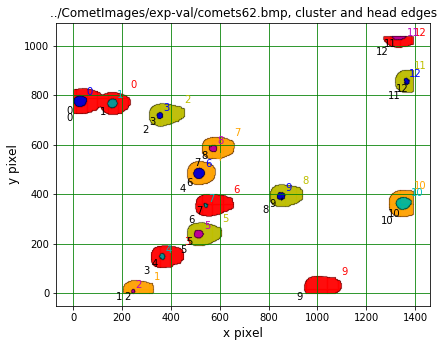

 
Date and time 2021-12-15 14:44:25.977558
Time since last check is 0:00:01.541915


In [11]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
# Figure control
xOffMax = 2
yOffMax = 2
xOffMin = 30
yOffMin = 30
mSize = 0.001
#
# Colour tables for plots
nColTab1 = 3
colorTab1 = ['r', 'orange', 'y']
#
nColTab2 = 3
colorTab2 = ['b', 'c', 'm']
#
fig = plt.figure(figsize=(6.7, 5.2))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nLastClEx = 0
nLastClEd = 0
nCol1 = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                s = mSize, c = colorTab1[nCol1], marker = 'o')
    rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
    cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
    plt.text(cLab, rLab, str(nC), color = colorTab1[nCol1])
    #
    nCol1 += 1
    if nCol1 > nColTab1 - 1:
         nCol1 = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Edges
    nHereClEd = nInClusEd[nC]
    plt.scatter(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd], rPixelsClEd[nLastClEd:nLastClEd + nHereClEd],
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - yOffMin
    cLab = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd]) - xOffMin
    plt.text(cLab, rLab, str(nC), color = 'k')
    #
    nLastClEd = nLastClEd + nHereClEd
    #
nCol2 = 0
#
nLastHd = 0
nLastHdEd = 0
for nH in range(0, nHead):
    #
    # Heads
    nHereHd = nInHead[nH]
    plt.scatter(cPixelsHd[nLastHd:nLastHd + nHereHd], rPixelsHd[nLastHd:nLastHd + nHereHd], 
                s = mSize, c = colorTab2[nCol2], marker = 'o')
    rLab = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd]) + yOffMax
    cLab = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd]) + xOffMax
    plt.text(cLab, rLab, str(nH), color = colorTab2[nCol2])
    nCol2 = nCol2 + 1
    if nCol2 > nColTab2 - 1:
         nCol2 = 0
    #
    # Edges
    nHereHdEd = nInHeadEd[nH]
    plt.scatter(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd], 
                s = mSize, c = 'k', marker = 'o')
    rLab = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - yOffMin
    cLab = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd]) - xOffMin
    plt.text(cLab, rLab, str(nH), color = 'k')
    #
    nLastHd = nLastHd + nHereHd
    nLastHdEd = nLastHdEd + nHereHdEd
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot expanded clusters with original clusters

Can plot all clusters or "zoom in" on specific clusters.

Date and time 2021-12-15 14:44:28.139784
 


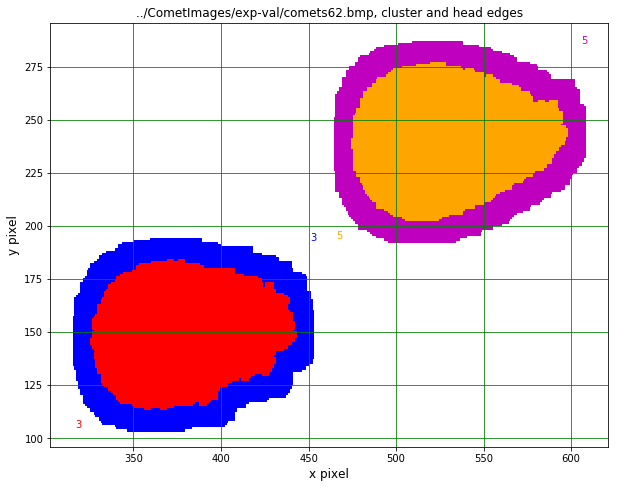

 
Date and time 2021-12-15 14:44:28.706679
Time since last check is 0:00:00.566895


In [12]:
import datetime
now = datetime.datetime.now()
print("Date and time",str(now))
#
#plotAll = True
plotAll = False
clusList = [3, 5]
#
# Figure control
xOffMax = 0
yOffMax = 0
xOffMin = 10
yOffMin = 10
mSize = 1
#
fig = plt.figure(figsize=(10, 7.8))
ax = fig.add_subplot(1, 1, 1)
plt.title(imFile + ", cluster and head edges", fontsize = 12)
plt.xlabel('x pixel', fontsize = 12)
plt.ylabel('y pixel', fontsize = 12)
#
nLastClEx = 0
nLastCl = 0
nCol1 = 0
nCol2 = 0
for nC in range(0, nClus):
    #
    # Expanded clusters
    nHereClEx = nInClusEx[nC]
    if plotAll or nC in clusList:
        plt.scatter(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx], rPixelsClEx[nLastClEx:nLastClEx + nHereClEx],
                    c = colorTab2[nCol2], marker = ',')
        rLab = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + yOffMax
        cLab = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx]) + xOffMax
        plt.text(cLab, rLab, str(nC), color = colorTab2[nCol2])
        #
        nCol2 += 2
        if nCol2 > nColTab2 - 1:
             nCol2 = 0
    #
    nLastClEx = nLastClEx + nHereClEx
    #
    # Clusters
    nHereCl = nInCluster[nC]
    if plotAll or nC in clusList:
        plt.scatter(cPixelsCl[nLastCl:nLastCl + nHereCl], rPixelsCl[nLastCl:nLastCl + nHereCl],
                    c = colorTab1[nCol1], marker = ',')
        rLab = np.amin(rPixelsCl[nLastCl:nLastCl + nHereCl]) - yOffMin
        cLab = np.amin(cPixelsCl[nLastCl:nLastCl + nHereCl]) - xOffMin
        plt.text(cLab, rLab, str(nC), color = colorTab1[nCol1])
        #
        nCol1 += 1
        if nCol1 > nColTab1 - 1:
             nCol1 = 0
    #
    nLastCl = nLastCl + nHereCl
#
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Select clusters by combining results from all thresholds

Select only low threshold clusters/edges (called wheels/rims in following) containing one high threshold cluster/edge (wheel/rim).

Produce and sort lists of coordinates that will be put into json file as "polygons". Sort according to the angles of the points about the centre of the rim. Choose the centre to be the mean position of the high threshold rim enclosed by the low threshold rim, or the mean position of the pixels in the low threshold rim.

Note that we need to add the first point to the end of the sorted list to close the polygon!

Date and time  2021-12-15 14:44:31.097160
 
Image size 1040 x 1392
Fiducial region, rows 5 to 1035 , columns 5 to 1387
Min number of points in wheel 500 , in rim 100
Rim size, row width 20 to 200 , column width 50 to 500
Max ratio of rim size to wheel area 0.1
 


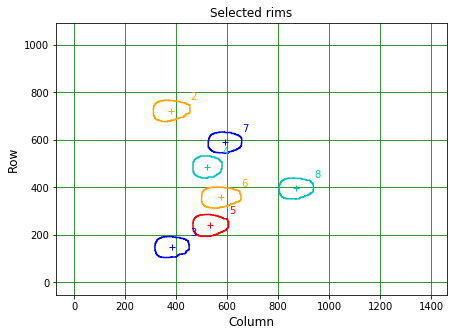

 
Number of polygons (nRimOut) 7
 


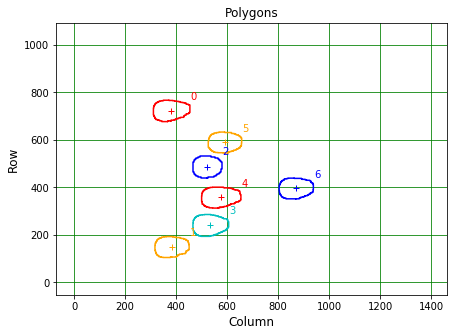

 
Date and time 2021-12-15 14:44:31.962510
Time since last check is 0:00:00.865350


In [13]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
debug = False
#
withLabels = True
#
# Choose low threshold or high threshold rim as centre in sorting procedure
centreLT = True
#
minRimPnts0 = 100
minWheelPnts0 = 500
rMin0 = 5
rMax0 = nRows - rMin0
cMin0 = 5
cMax0 = nCols - cMin0
rWidMin0 = 20
rWidMax0 = 200
cWidMin0 = 50
cWidMax0 = 500
maxRtoW = 0.1
print(" ")
print("Image size",nRows,"x",nCols)
print("Fiducial region, rows",rMin0,"to",rMax0,"\b, columns",cMin0,"to",cMax0)
print("Min number of points in wheel",minWheelPnts0,"\b, in rim",minRimPnts0)
print("Rim size, row width",rWidMin0,"to",rWidMax0,"\b, column width",cWidMin0,"to",cWidMax0)
print("Max ratio of rim size to wheel area",maxRtoW)
#
pnts_num = np.zeros(nClus).astype(int)
pnts_row = np.zeros((nClus, np.amax(nInClusEd)))
pnts_col = np.zeros((nClus, np.amax(nInClusEd)))
mean_row = np.zeros(nClus)
mean_col = np.zeros(nClus)
#
# Need additional entry in sorted arrays as must add initial point at end of array to complete polygon!
col_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
row_sorted = np.zeros((nClus, np.amax(nInClusEd) + 1))
#
# Text positions
rTextRow = 3
rTextCol = 3
wTextRow = 28
wTextCol = 28
#
fig = plt.figure(figsize=(7, 5))
plt.title("Selected rims", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
iSelRim = 0
nLastClEx = 0
nLastClEd = 0
for nC in range(0, nClus):
    #
    # Clusters
    nHereClEx = nInClusEx[nC]
    rMinCl = np.amin(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    cMinCl = np.amin(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    rMaxCl = np.amax(rPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    cMaxCl = np.amax(cPixelsClEx[nLastClEx:nLastClEx + nHereClEx])
    rWidCl = rMaxCl - rMinCl
    cWidCl = cMaxCl - cMinCl
    #
    # Edges
    nHereClEd = nInClusEd[nC] 
    rMinClEd = np.amin(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMinClEd = np.amin(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rMaxClEd = np.amax(rPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    cMaxClEd = np.amax(cPixelsClEd[nLastClEd:nLastClEd + nHereClEd])
    rWidClEd = rMaxClEd - rMinClEd
    cWidClEd = cMaxClEd - cMinClEd
    #
    rimToWheel = nInClusEd[nC]/nInClusEx[nC]
    #
    if (nHereClEd > minRimPnts0 and nHereClEx > minWheelPnts0 and
        rMinClEd > rMin0 and rMaxClEd < rMax0 and cMinClEd > cMin0 and cMaxClEd < cMax0 and  
        rWidClEd > rWidMin0 and rWidClEd < rWidMax0 and cWidClEd > cWidMin0 and cWidClEd < cWidMax0 and
        rimToWheel < maxRtoW):
        #
        nHeadsInClus = 0
        #
        nLastHd = 0
        nLastHdEd = 0
        for nH in range(0, nHead):
            #
            # Clusters
            nHereHd = nInHead[nH]
            rMinHd = np.amin(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMinHd = np.amin(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rMaxHd = np.amax(rPixelsHd[nLastHd:nLastHd + nHereHd])
            cMaxHd = np.amax(cPixelsHd[nLastHd:nLastHd + nHereHd])
            rWidHd = rMaxHd - rMinHd
            cWidHd = cMaxHd - cMinHd
            #
            # Edges
            nHereHdEd = nInHeadEd[nH]
            rMinHdEd = np.amin(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMinHdEd = np.amin(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rMaxHdEd = np.amax(rPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            cMaxHdEd = np.amax(cPixelsHdEd[nLastHdEd:nLastHdEd + nHereHdEd])
            rWidHdEd = rMaxHdEd - rMinHdEd
            cWidHdEd = cMaxHdEd - cMinHdEd
            #
            # Find any high threshold rims completely within the low threshold rim
            if (rMinHdEd > rMinClEd and rMaxHdEd < rMaxClEd and 
                cMinHdEd > cMinClEd and cMaxHdEd < cMaxClEd):
                #
                nHeadsInClus += 1
                nLastHdSel = nLastHd
                nLastHdEdSel = nLastHdEd
                nHereHdSel = nHereHd
                nHereHdEdSel = nHereHdEd
            #
            nLastHd = nLastHd + nHereHd
            nLastHdEd = nLastHdEd + nHereHdEd
        #
        # End of loop over heads
        #
        if nHeadsInClus == 1:
            # 
            # This rim accepted
            pnts_num[iSelRim] = nHereClEd
            pnts_row[iSelRim, 0:nHereClEd] = rPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            pnts_col[iSelRim, 0:nHereClEd] = cPixelsClEd[nLastClEd:nLastClEd + nHereClEd].astype(int)
            # 
            # Choose desired rim centre for definition of angle used for sorting rim points
            if centreLT:
                mean_row[iSelRim] = np.mean(pnts_row[iSelRim, 0:pnts_num[iSelRim]])
                mean_col[iSelRim] = np.mean(pnts_col[iSelRim, 0:pnts_num[iSelRim]])
            else:
                mean_row[iSelRim] = np.mean(rPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
                mean_col[iSelRim] = np.mean(cPixelsHdEd[nLastHdEdSel:nLastHdEdSel + nHereHdEdSel])
            #
            atan_pnts = np.arctan2(pnts_col[iSelRim, 0:pnts_num[iSelRim]] - mean_col[iSelRim],
                                   pnts_row[iSelRim, 0:pnts_num[iSelRim]] - mean_row[iSelRim])
            ind_sort = np.argsort(atan_pnts)
            #
            col_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_col[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            row_sorted[iSelRim, 0:pnts_num[iSelRim]] = pnts_row[iSelRim, ind_sort[0:pnts_num[iSelRim]]]
            plt.plot(col_sorted[iSelRim, 0:pnts_num[iSelRim]], row_sorted[iSelRim, 0:pnts_num[iSelRim]],
                     color = colorTab[nCol])
            plt.plot(mean_col[iSelRim], mean_row[iSelRim], marker = '+', color = colorTab[nCol])
            if withLabels:
                row_label = np.amax(pnts_row[iSelRim, 0:pnts_num[iSelRim]]) + rTextRow
                col_label = np.amax(pnts_col[iSelRim, 0:pnts_num[iSelRim]]) + rTextCol
                plt.text(col_label, row_label, str(nC), color = colorTab[nCol])
            nCol = nCol + 1
            if nCol > nColTab - 1:
                 nCol = 0
            #
            iSelRim += 1
        #
        # End of if statement, rim accepted
    #
    # End of if statement, cluster in fiducial region 
    nLastClEx = nLastClEx + nHereClEx
    nLastClEd = nLastClEd + nHereClEd
#
# End of loop over clusters
nRimOut = iSelRim
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
print(" ")
print("Number of polygons (nRimOut)",nRimOut)
#
fig = plt.figure(figsize=(7, 5))
plt.title("Polygons", fontsize = 12)
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
#
# Add first point (index zero) to end of array to ensure completion of polygon and then plot!
nCol = 0
for iRim in range(0, nRimOut):
    col_sorted[iRim, pnts_num[iRim]] = col_sorted[iRim, 0]
    row_sorted[iRim, pnts_num[iRim]] = row_sorted[iRim, 0]
    pnts_num[iRim] += 1
    plt.plot(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]],
                color = colorTab[nCol])
    plt.plot(mean_col[iRim], mean_row[iRim], marker = '+', color = colorTab[nCol])
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]]) + rTextRow
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]]) + rTextCol
        plt.text(col_label, row_label, str(iRim), color = colorTab[nCol])
    nCol = nCol + 1
    if nCol > nColTab - 1:
         nCol = 0
#
plt.xlim(-0.05*nCols, 1.05*nCols)
plt.ylim(-0.05*nRows, 1.05*nRows)
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Make json file

In [14]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
from IPython.display import JSON
import os
import json
#
im_file = imFile
im_file_size = os.path.getsize(im_file)
dict_name = fileName + str(im_file_size)
number_comets = nRimOut
#
comets = {}
comets[dict_name] = {
    "fileref": "",
    "size": im_file_size,
    "filename": im_file,
    "base64_img_data": "",
    "file_attributes": {},
    "regions": {str(n_comet):
                {"shape_attributes":
                 {"name": "polygon",
                  "all_points_x":
                  col_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                  "all_points_y":
                  row_sorted[n_comet, 0:pnts_num[n_comet]].astype(int).tolist(),
                 "region_attributes": {}}}
                for n_comet in range(0, number_comets)}
}
#
out_file_name = 'watershed_comets10TEST.json'
with open(out_file_name, 'w') as outfile:
    json.dump(comets, outfile)
#
out_file_size = os.path.getsize(out_file_name)
print(" ")
print("im_file_size",im_file_size)
print("dict_name",dict_name)
print("out_file_size",out_file_size)
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

Date and time  2021-12-15 14:44:39.904806
 
im_file_size 1448758
dict_name comets62.bmp1448758
out_file_size 32500
 
Date and time 2021-12-15 14:44:39.947091
Time since last check is 0:00:00.042285


## Look at json file

In [134]:
from pprint import pprint
#JSON(comets)
pprint(comets, width=10)

{'comets62.bmp1448758': {'base64_img_data': '',
                         'file_attributes': {},
                         'filename': '../CometImages/exp-val/comets62.bmp',
                         'fileref': '',
                         'regions': {'0': {'shape_attributes': {'all_points_x': [379,
                                                                                 379,
                                                                                 379,
                                                                                 378,
                                                                                 377,
                                                                                 376,
                                                                                 375,
                                                                                 374,
                                                                                 373,
              

## Plot polygons

Make plot of all polygons in the json file.

Date and time  2021-12-15 14:51:29.159103
 


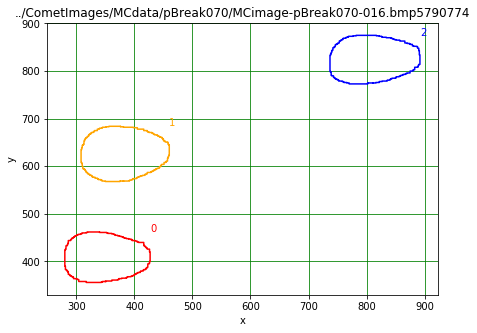

 
Date and time 2021-12-15 14:51:30.264111
Time since last check is 0:00:01.105008


In [15]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
import pandas as pd
#
withLabels = True
#
polyPic = np.zeros((nRows, nCols))
#
json_file = 'comets.json'
polygons_df = pd.read_json(json_file)
#
# Set up colour list for plots
n_colours = 8
colour_list = ['r', 'orange', 'b', 'indigo', 'violet', 'c', 'm', 'k']
#
rTextRow = 0
rTextCol = 0
#
# Loop over all files in the dataframe
iPoly = 0
for file in polygons_df:
    #
    # Make figure for each file
    plt.figure(figsize = (7, 5))
    plt.title(file)
    plt.xlabel("x")
    plt.ylabel("y")
    n_col = 0
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        plt.plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
        plt.grid(color = 'g')
        #
        if withLabels:
            row_label = np.amax(y_coords) + rTextRow
            col_label = np.amax(x_coords) + rTextCol
            plt.text(col_label, row_label, str(key), color = colour_list[n_col])
        #
        # Make picture of polygons
#        plotPic += 
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    print(" ")
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))

## Plot individual polygons

Make plot of each of comets in json file (compare scatter plot with plot of line generating polygon).

Date and time  2021-12-15 14:51:34.228632
 
key 0
key 1
key 2


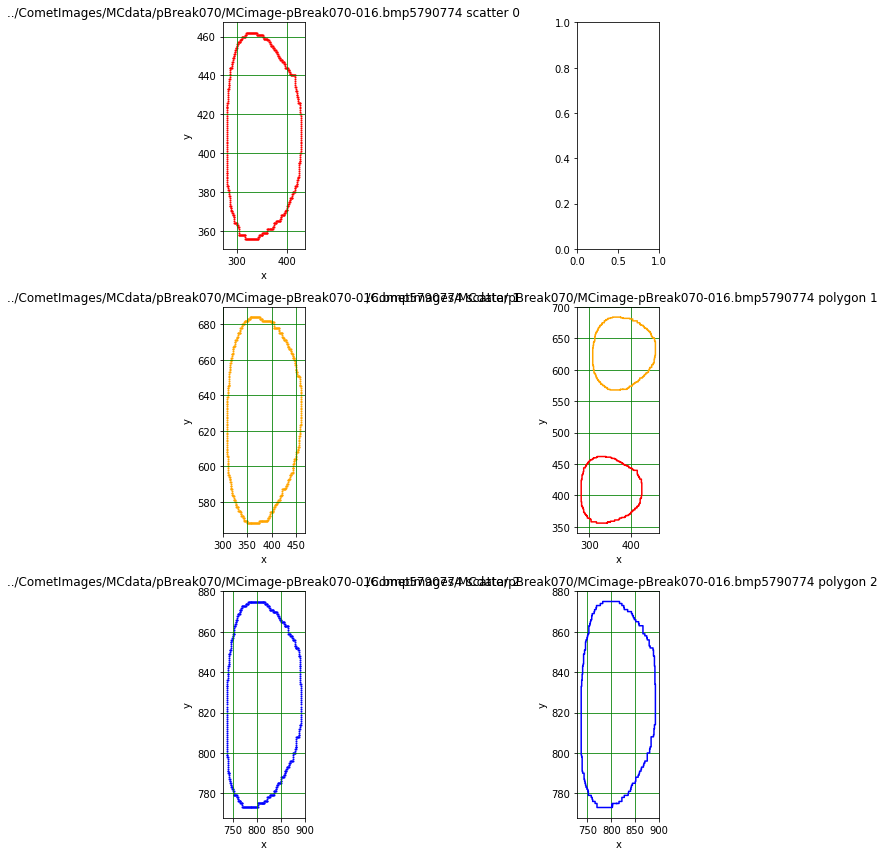

 
Date and time 2021-12-15 14:51:35.410413
Time since last check is 0:00:01.181781
Time since notebook start is 0:08:23.262312


In [16]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
# Loop over all files in the dataframe
for index, file in enumerate(polygons_df):
    #
    # Make figure for each comet
    print(" ")
    number_comets = len(polygons_df[file]['regions'])
    fig1, axs = plt.subplots(number_comets, 2, figsize = (10, 4*number_comets))
    n_plot = 0
    n_col = 0
    #
    for key in polygons_df[file]['regions']:
        #
        # Extract coordinates of polygons and plot
        x_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_x'])) 
        y_coords = np.array((polygons_df[file]['regions'][key]['shape_attributes']['all_points_y']))
        #
        print("key",key)
        if int(key) < 1:
            axs[0,0].set_title(file + " scatter " + key)
            axs[0,0].set_xlabel("x")
            axs[0,0].set_ylabel("y")
            axs[0,0].scatter(x_coords, y_coords, s = 1.0, color = colour_list[n_col])
            axs[0,0].grid(color = 'g')
            #
            axs[1,1].set_title(file + " polygon " + key)
            axs[1,1].set_xlabel("x")
            axs[1,1].set_ylabel("y")
            axs[1,1].plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
            axs[1,1].grid(color = 'g')
        else:
            axs[int(key), 0].set_title(file + " scatter " + key)
            axs[int(key), 0].set_xlabel("x")
            axs[int(key), 0].set_ylabel("y")
            axs[int(key), 0].scatter(x_coords, y_coords, s = 1.0, color = colour_list[n_col])
            axs[int(key), 0].grid(color = 'g')
            #
            axs[int(key), 1].set_title(file + " polygon " + key)
            axs[int(key), 1].set_xlabel("x")
            axs[int(key), 1].set_ylabel("y")
            axs[int(key), 1].plot(x_coords, y_coords, linestyle = '-', color = colour_list[n_col])
            axs[int(key), 1].grid(color = 'g')
        #
        n_col += 1
        if n_col == n_colours:
            n_col = 0
        #
    plt.tight_layout()
    plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

## Plot polygons on original image

Date and time  2021-12-15 14:51:38.255125
 
 


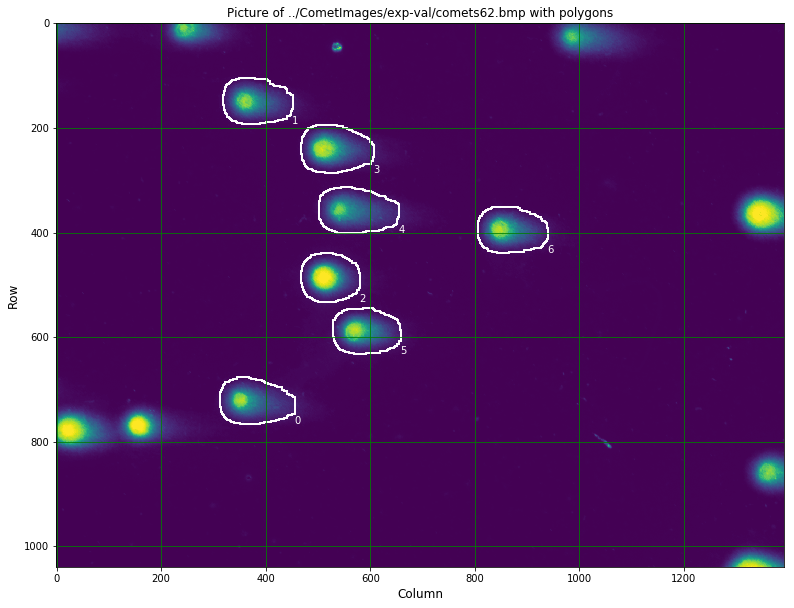

 
Date and time 2021-12-15 14:51:39.095828
Time since last check is 0:00:00.840703
Time since notebook start is 0:08:26.947727


In [17]:
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
withLabels = True
#
print(" ")
plt.figure(figsize=(14, 10))
plt.title("Picture of " + imFile + " with polygons")
plt.xlabel('Column', fontsize = 12)
plt.ylabel('Row', fontsize = 12)
r_points, c_points = np.indices(imgGrey.shape)
#colors = imgGrey.reshape((-1, 3))  #3 for 4 needed in second index dependant on image dimensions
colors = imgGrey.reshape((-1, 4))
#plt.scatter(c_points, r_points, c = colors, s = 1)
plt.imshow(imgGrey)
#
for iRim in range(0, nRimOut):
    plt.scatter(col_sorted[iRim, 0:pnts_num[iRim]], row_sorted[iRim, 0:pnts_num[iRim]], 
                s = 1, marker = ',',c = 'w')
    if withLabels:
        row_label = np.amax(pnts_row[iRim, 0:pnts_num[iRim]])
        col_label = np.amax(pnts_col[iRim, 0:pnts_num[iRim]])
        plt.text(col_label, row_label, str(iRim), color = 'w')
    #
#
plt.grid(color = 'g')
print(" ")
plt.show()
#
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))
print("Time since notebook start is",str(now - startNB))

### Now use matplotlib Path routine to define all pixels that lie within a polygon

Date and time  2021-11-10 16:59:19.346311
pnts_num[iRim] is:  363
shape of polygon is:  (363, 2)
comPix is:  6622
bkgPix is:  4191779


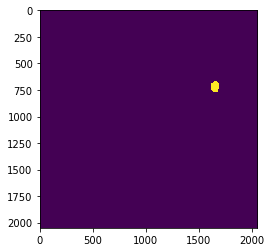

 
Date and time 2021-11-10 17:00:21.947803
Time since last check is 0:01:02.601492


In [30]:
import numpy as np
import matplotlib.path as pltPath
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
mask = np.zeros((nRows +1, nCols+1, nRimOut))
#
rows = np.linspace(0, nRows, nRows +1)
cols = np.linspace(0, nCols, nCols +1)
cMesh, rMesh = np.meshgrid(cols, rows)
#
cFlat = cMesh.flatten()
rFlat = rMesh.flatten()
nPix = len(cFlat)
comPix = 0
bkgPix = 0
#
for iRim in range(0, nRimOut):
    print("pnts_num[iRim] is: ", pnts_num[iRim])
    points = pnts_num[iRim]
    polygon = np.zeros((points, 2))
    print("shape of polygon is: ", polygon.shape)
    polygon[:, 0] = col_sorted[iRim, 0:pnts_num[iRim]]
    polygon[:, 1] = row_sorted[iRim, 0:pnts_num[iRim]]
    poly_path = pltPath.Path(polygon)
    #point = (1250, 1250)
    for n in range(0, nPix):
        point = (cFlat[n].astype(int), rFlat[n].astype(int))
        #print("point is:", point)
        test = poly_path.contains_point(point)
        #print(" test is: ", test)
        #print("\nn is: ", n)
        #print("rFlat[n] and cFlat [n] are: ", rFlat[n], cFlat[n])
        row  = rFlat[n].astype(int)
        col = cFlat[n].astype(int)
        #print("row and col are: ", row, col)
        if test == True:
            mask[row, col, iRim] = 1
            comPix += 1
        else:
            mask[row, col, iRim] = 0
            bkgPix += 1

print("comPix is: ", comPix)
print("bkgPix is: ", bkgPix)
for n in range(0, nRimOut):
    plt.imshow(mask[:, :, n])
    plt.show()
#    
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))   

### Try scikit-image points_in_poly method. This returns a mask for all trialed points (may be more efficient)

Date and time  2021-11-10 17:00:22.481813
nPix is:  4198401
pnts_num[iRim] is:  363
shape of polygon is:  (363, 2)
shape of thisMask:  (4198401,)
comPix is:  0
bkgPix is:  0


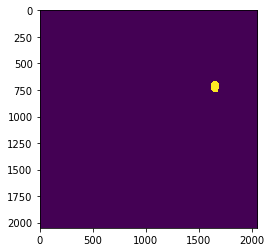

 
Date and time 2021-11-10 17:00:25.977584
Time since last check is 0:00:03.495771


In [31]:
import numpy as np
from skimage.measure import points_in_poly
import datetime
now = datetime.datetime.now()
print("Date and time ",str(now))
#
mask = np.zeros((nRows +1, nCols+1, nRimOut))
#
rows = np.linspace(0, nRows, nRows +1)
cols = np.linspace(0, nCols, nCols +1)
cMesh, rMesh = np.meshgrid(cols, rows)
#
cFlat = cMesh.flatten()
rFlat = rMesh.flatten()
nPix = len(cFlat)
print("nPix is: ", nPix)
imgPixels = np.zeros((nPix, 2))
imgPixels[:, 0] = cFlat
imgPixels[:, 1] = rFlat
comPix = 0
bkgPix = 0
#
for iRim in range(0, nRimOut):
    print("pnts_num[iRim] is: ", pnts_num[iRim])
    points = pnts_num[iRim]
    polygon = np.zeros((points, 2))
    print("shape of polygon is: ", polygon.shape)
    polygon[:, 0] = col_sorted[iRim, 0:pnts_num[iRim]]
    polygon[:, 1] = row_sorted[iRim, 0:pnts_num[iRim]]
    thisMask = points_in_poly(imgPixels, polygon)
    print("shape of thisMask: ", thisMask.shape)
    thisMask = np.reshape(thisMask, (nRows+1, nCols+1))
    mask[:, :, iRim] = thisMask
    """
    for n in range(0, nPix):
        point = (cFlat[n].astype(int), rFlat[n].astype(int))
        #print("point is:", point)
        #test = poly_path.contains_point(point)
        #print(" test is: ", test)
        #print("\nn is: ", n)
        #print("rFlat[n] and cFlat [n] are: ", rFlat[n], cFlat[n])
        row  = rFlat[n].astype(int)
        col = cFlat[n].astype(int)
        #print("row and col are: ", row, col)
        if test == True:
            mask[row, col, iRim] = 1
            comPix += 1
        else:
            mask[row, col, iRim] = 0
            bkgPix += 1
    """
print("comPix is: ", comPix)
print("bkgPix is: ", bkgPix)
for n in range(0, nRimOut):
    plt.imshow(mask[:, :, n])
    plt.show()
#    
then = now
now = datetime.datetime.now()
print(" ")
print("Date and time",str(now))
print("Time since last check is",str(now - then))   

Date and time  2021-11-11 16:14:34.531617
i is:  ../CometImages/exp-val/comets62.bmp1448758
j is:  fileref
j is:  base64_img_data
j is:  filename
j is:  size
j is:  file_attributes
j is:  regions
length of dictionary is:  1
dict_name is:  ../CometImages/exp-val/comets62.bmp1448758
fileName is:  ../CometImages/exp-val/comets62.bmp
i is:  ../CometImages/exp-val/comets62.bmp1448758
j is:  fileref
j is:  base64_img_data
j is:  filename
j is:  size
j is:  file_attributes
j is:  regions
length of dictionary is:  1
dict_name is:  ../CometImages/exp-val/comets62.bmp1448758
fileName is:  ../CometImages/exp-val/comets62.bmp
 
Date and time 2021-11-11 16:14:52.863711
Time since last check is 0:00:18.332094
